<a href="https://colab.research.google.com/github/nick-leland/ascii_diffusion/blob/main/Diffusion_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Notes

This notebook will contain all of my notes on general diffusion.  We may branch into VAE's as well to explore other technology, the goal is to eventually break into world modeling and data generation.

To do this I will need some sample images.  In order to find these, I will be using https://picsum.photos/, which you can use to find an image of a target resolution size.  I will have these pulled from my google drive.  

In [30]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
from numpy import random
from PIL import Image
import matplotlib.pyplot as plt

array([[[ 83,  72,  52],
        [ 84,  73,  53],
        [ 85,  74,  54],
        ...,
        [108,  91,  81],
        [ 98,  81,  71],
        [113,  96,  86]],

       [[ 86,  75,  55],
        [ 86,  75,  55],
        [ 87,  76,  56],
        ...,
        [104,  87,  77],
        [ 98,  81,  71],
        [113,  96,  86]],

       [[ 83,  72,  54],
        [ 84,  73,  55],
        [ 85,  74,  56],
        ...,
        [ 99,  85,  72],
        [104,  90,  77],
        [116, 102,  89]],

       ...,

       [[210, 206, 194],
        [207, 203, 191],
        [221, 217, 205],
        ...,
        [104, 104, 102],
        [ 99,  99,  97],
        [ 99,  99,  97]],

       [[216, 213, 198],
        [225, 222, 207],
        [229, 226, 211],
        ...,
        [ 99, 101,  98],
        [ 96,  98,  95],
        [ 98, 100,  97]],

       [[227, 224, 209],
        [233, 230, 215],
        [232, 229, 214],
        ...,
        [125, 127, 124],
        [127, 129, 126],
        [129, 131, 128]]], dtype=uint8)
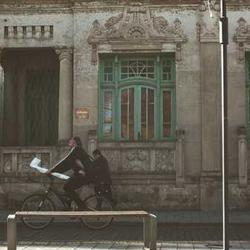

In [32]:
sample = Image.open('/content/drive/MyDrive/409-250x250.jpg')
np_sample = np.array(sample)
np_sample

## 1.1 Gaussian Diffusion

Gaussian diffusion is the act of taking images that have had noise applied to them, then _denoising_ the image in order to gain a deeper understanding of the framework the image is built on.

### Foward Process
The first step to diffusion is to inject our images with noise.  This process, known as a _Forward Process_, can be described with the following mathematical formula.

$\mathbf{x}_{t+1} := \mathbf{x}_t + \mathcal{n}_t, \quad \mathcal{n}_t \sim \mathcal{N}(0, \sigma^2)$

Essentially, we are creating a target distribution $\mathcal{p}^*$ that is generated using a dataset we have identified.  Then using this formula, we generate multiple random variables ($\mathcal{x}_0, \mathcal{x}_1, \mathcal{x}_2, ..., \mathcal{x}_t$).  With these random variables (in our case images) we can identify that we slowly begin to approach the Gaussian Distribution, therefore, we can sample the Gaussian rather then our originally defined $\mathcal{p}^*$ distribution.  



We can evaluate the differences between the two distributions using a formula known as KL Divergence:

The **Kullback-Leibler (KL) divergence** between two distributions $P$ and $Q$ is defined as:

$D_{KL}(P \| Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)}$


or, for continuous distributions:

$D_{KL}(P \| Q) = \int_{-\infty}^{\infty} P(x) \log \frac{P(x)}{Q(x)} \, dx$

where:

- $P(x)$ is the true probability distribution.
- $Q(x)$ is the approximating (or target) probability distribution.
- $D_{KL}(P \| Q)$ is the KL divergence, which is non-negative and measures how much information is lost when $Q$ is used to approximate $P$.

So would we be utilizing Continuous or Discrete variables? You might think initially that due to the format of image files given as:

$\mathbf{p}_{ij} \in [0, 255]^3 \quad \text{for } i = 1, \dots, W \text{ and } j = 1, \dots, H$

Realistically though, our model will think within the spaace of 0-1 instances which we will then convert into our discrete space.


### Other Potentially Useful Definitions
Probability Density Function

$p(\mathbf{x}) = \frac{1}{(2\pi)^{\frac{d}{2}} |\mathbf{\Sigma}|^{\frac{1}{2}}} \exp \left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)$

where:

- $\mathbf{x}$ is a $d$-dimensional random vector.
- $\boldsymbol{\mu}$ is the mean vector.
- $\mathbf{\Sigma}$ is the covariance matrix.

Covariance Matrix

$\text{Cov}(X, Y) = \mathbb{E}[(X - \mathbb{E}[X])(Y - \mathbb{E}[Y])]$

where:

- $\mathbb{E}[X]$ is the expected value $(mean)$ of $X.$

- $\mathbb{E}[Y]$ is the expected value $(mean)$ of $Y.$

Now we propose a subproblem

_"Given a sample marginally distributed as $p_t$, introduce a sample marginally distributed as $p_{t-1}$"_

Now that we have established our noisy image, the goal is to create a model which can identify features and effectively _denoise_ our image.  This method is known as a **reverse sampler**.

We would effectively move through each position until indefinitely reating our original, target distribution ($p_0 = p^*$).  This leads us to the primary idea behind diffusion, rather then learning how to go from a noised image back in one step (I believe this is similar to how VAE's function), we instead go through multiple steps and learn the process behind each.  

### DDPM Sampler
We can construct reverse samplers in many different ways, the DDPM Sampler is known as the _standard diffusion sampler_.  This uses a very simple strategy, at a time $t$, given the input $z$, where $z$ is a sample from $p_t$, oputput a sample from the conditional distribution.

$p(x_{t-1} | x_t = z)$

This seems very simple, but realistically there is much more to the entire process.  If we were to have a model for every single step of $x_t$, this would be quite a large process.  The key is identifying the per-step noise $\sigma$.  If this amount of noise that we are adding per step is small enough, the distribution becomes simple.

Let us observe the following definition:

**Diffusion Reverse Process**: For small $σ$, and the Gaussian diffusion process defined in (1), the conditional distribution $p(x_{t-1}|x_t)$ is itself close to Gaussian.  That is, for all the times $t$ and conditioning $z ∈ ℝ^d$, there exists some mean parameter $\mu ∈ ℝ^d$ such that:

$p(x_{t-1} | x_t = z) ≈ \mathcal{N}(x_{t-1} ; μ, σ^2)$

There is a lot going on here, let's talk about it in a bit more detail.  Essentially speaking, if we have the distribution that we are trying to understand, by targeting a certain point and minimizing our $σ$ value, the distribution approaches that of the Gaussian at a much more aggressive rate.  This allows us to have one missing value to focus on, the mean ($μ$)


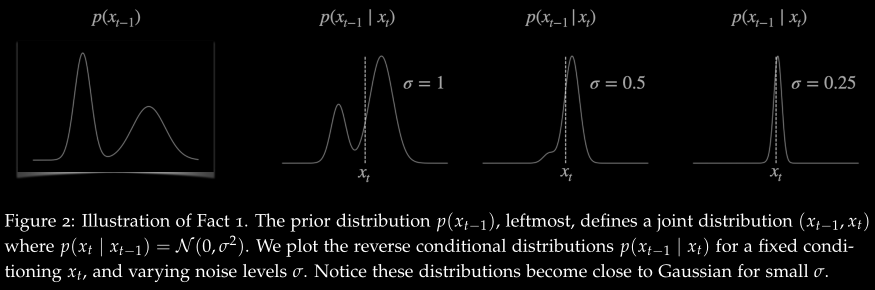



### Diffusion Reverse Process Reiterated
_This is so important they decide to restate this, let's do the same here_

For a given time $t$, and conditioning value $x_t$, learning the mean of $p(x_{t-1}|x_t)$ is sufficient to learn the full conditional distribution $p(x_{t-1} | x_t)$

How do we solve this new problem of determing our mean($\mu$)?
**We can use a simple linear regression!** We can perform this by using a simple regression loss function.  Let's dive into the functions behind this.  

To begin, we have a joint distribution:
$(x_{t-1}, x_t)$

We would like to estimate
$𝔼[x_{t-1} | x_t]$

### Standard Regression Loss

Before looking into this function, remember that for any distribution over $(x, y)$, we have: $\arg\min_{f}𝔼||f(x)-y||^2=𝔼[y|x]$

$$
\mu_{t-1}(z) := \mathbb{E}[x_{t-1} \mid x_t = z] \tag{4}
$$

$$
\mu_{t-1} = \arg\min_{f : \mathbb{R}^d \rightarrow \mathbb{R}^d} \mathbb{E}_{x_t, x_{t-1}} \left\| f(x_t) - x_{t-1} \right\|_2^2 \tag{5}
$$

$$
= \arg\min_{f : \mathbb{R}^d \rightarrow \mathbb{R}^{d \times d'}} \mathbb{E}_{x_t, x_{t-1}, \eta_t} \left\| f(x_{t-1} + \eta_t) - x_{t-1} \right\|_2^2 \tag{6}
$$

Essentially, we are optimizing the $\mu$ for the minimum difference between our given distribution and the noise that is generated on the image.  $x_0$ is from our target distribution $p^*$. When target $p^*$ is a distribution on images, then the corresponding regression problem is exactly an **image denoising objective**.  This objective can then be approached with deep learning techniques such as CNN's.  

Through this process we have taken our goal of **learning to sample from an arbitrary distribution** to the standard **problem of regression**.

# Adding Noise to our Image

Now that we have a brief understanding of the process in which we will be generating our forward steps and then working through the Diffusion Reverse Process, why don't we iteratively start to apply this onto a sample image.

Let's start by just verifying we have loaded our sample image.  In our case, we are dealing with a color, square photo that is 250 pixels wide.

array([[[ 83,  72,  52],
        [ 84,  73,  53],
        [ 85,  74,  54],
        ...,
        [108,  91,  81],
        [ 98,  81,  71],
        [113,  96,  86]],

       [[ 86,  75,  55],
        [ 86,  75,  55],
        [ 87,  76,  56],
        ...,
        [104,  87,  77],
        [ 98,  81,  71],
        [113,  96,  86]],

       [[ 83,  72,  54],
        [ 84,  73,  55],
        [ 85,  74,  56],
        ...,
        [ 99,  85,  72],
        [104,  90,  77],
        [116, 102,  89]],

       ...,

       [[210, 206, 194],
        [207, 203, 191],
        [221, 217, 205],
        ...,
        [104, 104, 102],
        [ 99,  99,  97],
        [ 99,  99,  97]],

       [[216, 213, 198],
        [225, 222, 207],
        [229, 226, 211],
        ...,
        [ 99, 101,  98],
        [ 96,  98,  95],
        [ 98, 100,  97]],

       [[227, 224, 209],
        [233, 230, 215],
        [232, 229, 214],
        ...,
        [125, 127, 124],
        [127, 129, 126],
        [129, 131, 128]]], dtype=uint8)
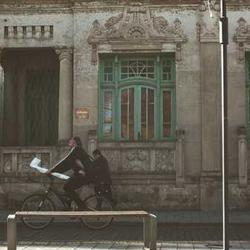

In [33]:
np_sample

Now we can begin to define the aspects of adding noise to an image.  We need to determine the $\sigma$ which will adjust how aggressively the noise is added to the image.  A smaller $\sigma$ will require more steps ($t$) in order to completely noise the image.  The baseline image is our $x_0$ and as we add noise we will be moving about $x_{t+1}$.  

In [43]:
sigma = 0.01
mean = 0

In [93]:
noise_step = np.random.normal(mean, sigma, (250, 250, 3))
noise_step.max(), noise_step.min()

(0.04578641664513937, -0.044681741163085834)

## Normalizing the Image

Our image is within the color range of $(0-255)$.  We now write a function that will take this image and normalize the image to a range of $[-1, 1]$.  With the normalized function, we will be able to add our noise values, then convert the array back to the appropriate image format $(0-255)$.

In [56]:
np_sample.mean(), np_sample.max(), np_sample.min()

(91.62656, 255, 11)

In [65]:
def normalization(input_array):
    return (input_array / 127.5) -1

def denormalization(input_array):
    output = (input_array + 1) * 127.5

    # Now provide clipping
    output = np.clip(output, 0, 255)

    # Convert to the original data type (uint8)
    output = output.astype(np.uint8)

    return output

In [66]:
normalized_np_sample = normalization(np_sample)
normalized_np_sample.mean(), normalized_np_sample.max(), normalized_np_sample.min()

(-0.2813603137254902, 1.0, -0.9137254901960784)

Before we proceed we will double check our normalization function by converting it back to an image array with the original scale, and verify that no information was lost.

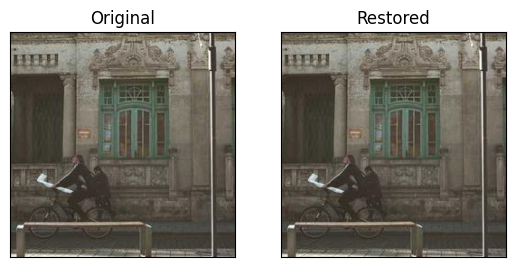

In [71]:
restored = denormalization(normalized_np_sample)
np_sample, restored

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np_sample)
axarr[1].imshow(restored)
axarr[0].set_title('Original')
axarr[1].set_title('Restored')
axarr[0].get_xaxis().set_visible(False)
axarr[0].get_yaxis().set_visible(False)
axarr[1].get_xaxis().set_visible(False)
axarr[1].get_yaxis().set_visible(False)
plt.show()

Visually these images look exactly the same, however, there will always be some loss due to floating point conversions.  

In [76]:
np.unique((np_sample - restored), return_counts=True)

(array([0, 1], dtype=uint8), array([177794,   9706]))

In [88]:
np.unique((np_sample[:, :, 0] - restored[:, :, 0]), return_counts=True)[1][1], np.unique((np_sample[:, :, 1] - restored[:, :, 1]), return_counts=True)[1][1], np.unique((np_sample[:, :, 2] - restored[:, :, 2]), return_counts=True)[1][1],

(1836, 2786, 5084)

As you can see here, while it doesn't visually seem like it, there are 9706 pixels (out of 187,500 pixels) that are incorrect.  These are distributed with 1836 errors on the Red layer, 2786 on the Green Layer and 5084 on the Blue layer.  

### Conversion Loss, Image or Noise?

Originally I questioned whether or not we would be better off dealing with this conversion loss on the noise layer rather then the image.  Because we will be adding multiple layers of noise to the image, we are better off applying this noise, then truncating the results using numpy's clipping feature and preserving the precision within the Gaussian function as the precision we would cut if we truncated the Gaussian function will severely add up over the course of the many steps of addding noise we would be performing.

array([[[128, 126, 127],
        [126, 127, 127],
        [127, 126, 129],
        ...,
        [126, 125, 128],
        [127, 129, 127],
        [125, 127, 128]],

       [[129, 125, 127],
        [125, 126, 128],
        [129, 127, 127],
        ...,
        [127, 128, 128],
        [127, 125, 127],
        [127, 126, 128]],

       [[127, 129, 128],
        [126, 125, 127],
        [128, 128, 128],
        ...,
        [127, 127, 128],
        [128, 128, 127],
        [127, 127, 127]],

       ...,

       [[127, 129, 129],
        [126, 126, 128],
        [127, 126, 127],
        ...,
        [126, 126, 128],
        [125, 126, 127],
        [126, 130, 127]],

       [[128, 127, 128],
        [127, 127, 128],
        [126, 127, 129],
        ...,
        [126, 126, 127],
        [126, 125, 127],
        [127, 127, 130]],

       [[128, 127, 126],
        [129, 125, 128],
        [130, 127, 125],
        ...,
        [128, 129, 128],
        [126, 125, 127],
        [128, 126, 126]]], dtype=uint8)
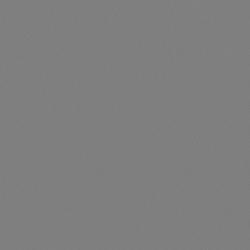

In [94]:
denormalization(noise_step)

In [105]:
def add_noise(input_array, sigma):
    mean = 0
    noise_step = np.random.normal(mean, sigma, (250, 250, 3))
    return input_array + noise_step, denormalization(input_array + noise_step)

array([[[ 53,  50, 116],
        [ 88,  73, 123],
        [ 13,  72, 129],
        ...,
        [ 94, 131, 122],
        [ 82,  86,  64],
        [ 66, 156,  95]],

       [[186,  60,   0],
        [108,  93,  11],
        [105, 179,   0],
        ...,
        [ 74, 244,  84],
        [  0,  66,  79],
        [ 22,  72,  72]],

       [[109,   0,  22],
        [ 80, 130, 141],
        [ 32,  98,  33],
        ...,
        [104,  56,  20],
        [ 12,   0,  44],
        [ 90, 210, 138]],

       ...,

       [[177,  88, 255],
        [171, 246, 143],
        [134, 201, 240],
        ...,
        [134, 178,  84],
        [127,  77, 108],
        [ 91, 136, 231]],

       [[248, 255, 178],
        [255, 167, 122],
        [210, 202, 144],
        ...,
        [200,  54, 136],
        [107, 128,  39],
        [128, 164, 167]],

       [[208, 231, 174],
        [225, 221, 203],
        [255,  98, 120],
        ...,
        [132, 171, 147],
        [184, 145, 130],
        [116, 153, 118]]], dtype=uint8)
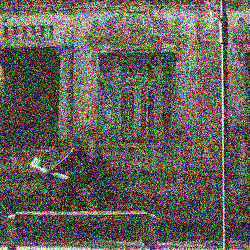

In [106]:
x_1, x_1_output = add_noise(normalized_np_sample, .5)

x_1_output

array([[[162,   4, 126],
        [129,   0, 125],
        [ 10,  59, 189],
        ...,
        [134, 208, 116],
        [184,  42,   0],
        [ 25, 106, 133]],

       [[224,  58,   0],
        [241,  62,   0],
        [ 75, 205,   0],
        ...,
        [ 72, 195,  75],
        [ 83,  94, 139],
        [ 93, 120, 159]],

       [[187,   0,  40],
        [146, 140, 168],
        [ 50,  78,   0],
        ...,
        [ 22,   7,  36],
        [ 10,   0, 104],
        [  6, 215,  34]],

       ...,

       [[228,  13, 255],
        [182, 255, 109],
        [110, 237, 204],
        ...,
        [196, 144,  30],
        [148, 183,  36],
        [ 29, 239, 199]],

       [[228, 255, 209],
        [255, 147,  40],
        [255, 110,   0],
        ...,
        [112,  35, 233],
        [  0, 183,  25],
        [ 74, 215,  82]],

       [[106, 248, 255],
        [194, 133, 164],
        [255,  60,  32],
        ...,
        [188, 255, 187],
        [100, 129,   3],
        [137,  86, 104]]], dtype=uint8)
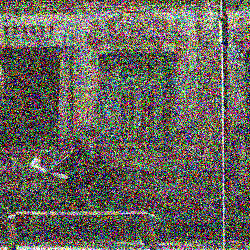

In [107]:
x_2, x_2_output = add_noise(x_1, .5)

x_2_output

array([[[255,   0, 152],
        [ 67,  13,  47],
        [  0, 125,  25],
        ...,
        [172, 168, 103],
        [252,   0,   0],
        [ 39, 255, 172]],

       [[161,  58,   0],
        [ 88,  69,   0],
        [ 53, 201,  63],
        ...,
        [138,  73,  12],
        [ 83, 147, 152],
        [ 93, 113,  75]],

       [[217,   0,   8],
        [180, 144, 205],
        [ 85,  92,   0],
        ...,
        [ 48,   0,  74],
        [  0,   0, 195],
        [ 82, 214,   0]],

       ...,

       [[255,  64, 248],
        [156, 255, 201],
        [165, 242, 207],
        ...,
        [229, 120,  51],
        [ 82, 137,  68],
        [123, 255, 255]],

       [[243, 255, 255],
        [255,  14,  74],
        [255, 153,  45],
        ...,
        [ 81, 111, 255],
        [  0, 232,  87],
        [117, 132, 151]],

       [[182, 255, 255],
        [255, 187, 255],
        [255,  35,  37],
        ...,
        [220, 243, 125],
        [117, 196,   0],
        [182,  54, 106]]], dtype=uint8)
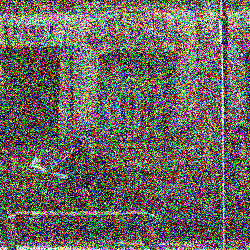

In [108]:
x_3, x_3_output = add_noise(x_2, .5)

x_3_output

# Left off here, Make this a function and specify the number of steps